In [50]:
# Импорты

import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


In [51]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [52]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [53]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

In [54]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


In [55]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [56]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [57]:
data.columns = ['ds', 'y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


<Axes: xlabel='ds'>

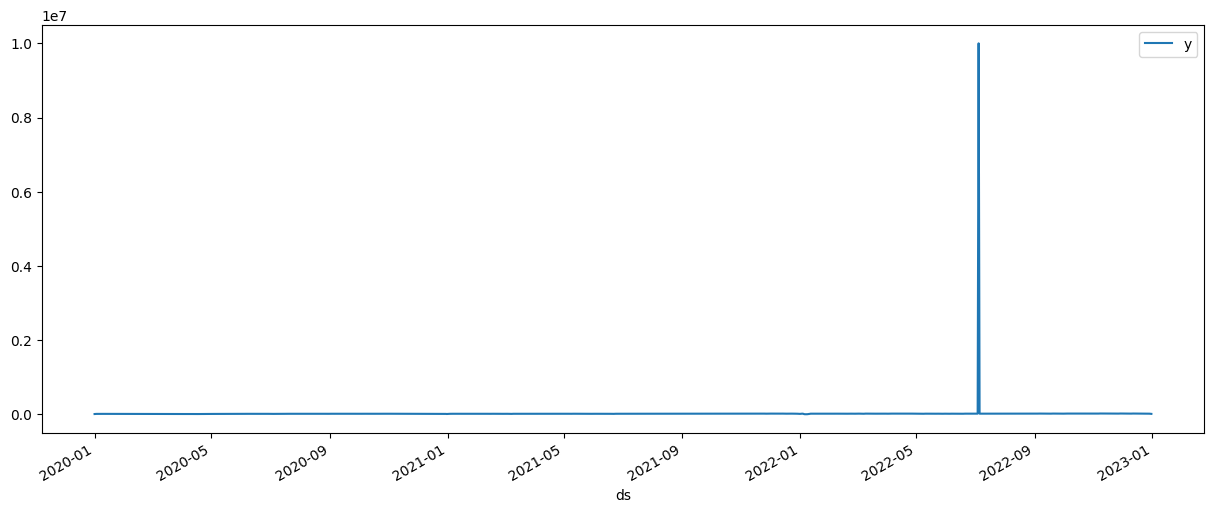

In [58]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [59]:
data.idxmax()

ds   2022-12-31
y    2022-07-05
dtype: datetime64[ns]

In [60]:
for i in range(2):
    data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_25760\1448882573.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


In [61]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

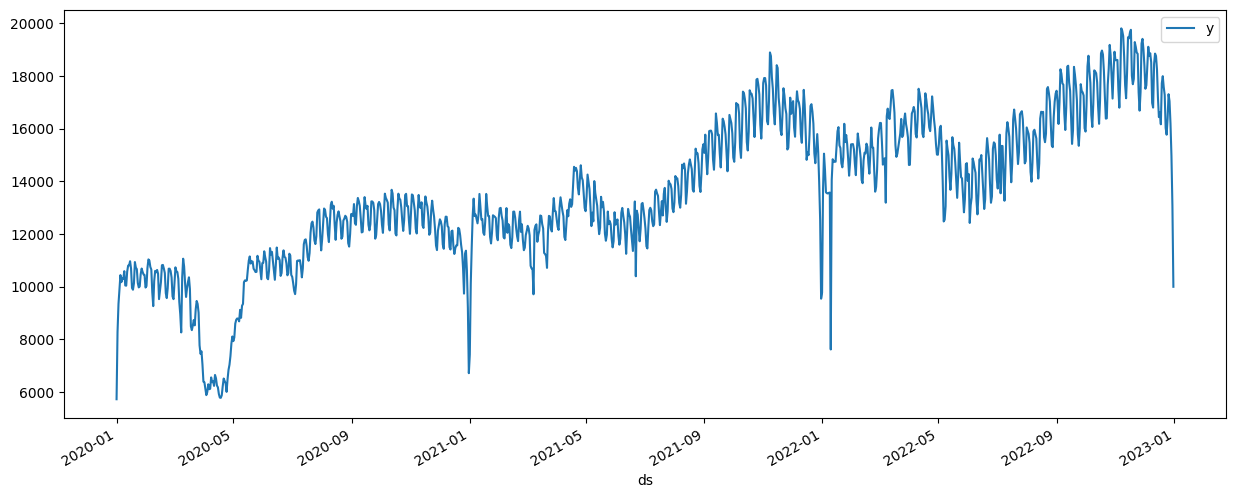

In [62]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [63]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03'))
            | (date >=pd.to_datetime('2023-03-23')) & (date <= pd.to_datetime('2023-04-23')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)

def is_covid(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-03-16')) & (date <= pd.to_datetime('2020-06-01')))

data['is_covid'] = data['ds'].apply(is_covid)
data['covid'] = data['is_covid'].apply(int)
data.head()
    

,ds,y,is_ramadan,ramadan,is_covid,covid
ds,,,,,,
2020-01-01,2020-01-01,5721.0,False,0,False,0
2020-01-02,2020-01-02,8274.0,False,0,False,0
2020-01-03,2020-01-03,9344.0,False,0,False,0
2020-01-04,2020-01-04,9864.0,False,0,False,0
2020-01-05,2020-01-05,10435.0,False,0,False,0


In [64]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0: 'holiday'})
df_holidays['ds'] = df_holidays.index
# df_holidays.index = df_holidays['ds']
df_holidays.head()

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22


In [65]:
# Функция для получения номера дня в году из даты
def get_day_of_year(ds):
    return pd.to_datetime(ds).dayofyear

# Преобразуем дату в номер дня в году
data['day_of_year'] = data['ds'].apply(get_day_of_year)

# Используем столбец 'y' в качестве целевой переменной
y = data['y'].values

# Используем номер дня в году в качестве признака
X = data[['day_of_year']]


In [66]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Индекс признака для разделения
        self.threshold = threshold  # Порог разделения
        self.left = left  # Левое поддерево
        self.right = right  # Правое поддерево
        self.value = value  # Значение в листовом узле

class DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        # Останавливаем рекурсию, если достигли максимальной глубины или узел чист
        if self.max_depth is not None and depth >= self.max_depth or len(np.unique(y)) == 1:
            return Node(value=np.mean(y))

        n_samples, n_features = X.shape
        best_loss = float('inf')
        best_feature, best_threshold = None, None

        # Поиск лучшего разделения по всем признакам и порогам
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature] <= threshold)
                right_indices = np.where(X[:, feature] > threshold)
                left_y, right_y = y[left_indices], y[right_indices]

                # Оценка качества разделения (среднеквадратичная ошибка)
                loss = self._mse(left_y) + self._mse(right_y)
                if loss < best_loss:
                    best_loss = loss
                    best_feature = feature
                    best_threshold = threshold
                    best_left_indices = left_indices
                    best_right_indices = right_indices

        # Рекурсивное построение дерева
        left = self._grow_tree(X[best_left_indices], y[best_left_indices], depth + 1)
        right = self._grow_tree(X[best_right_indices], y[best_right_indices], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _predict_value(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_value(x, node.left)
        else:
            return self._predict_value(x, node.right)

    def predict(self, X):
        return np.array([self._predict_value(x, self.tree) for x in X])


In [69]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

print("Размер обучающего набора:", X_train.shape[0])
print("Размер тестового набора:", X_test.shape[0])


Размер обучающего набора: 876
Размер тестового набора: 220


In [70]:
# Создаем экземпляр модели
decision_tree = DecisionTreeRegressor(max_depth=15)

# Предсказания на тестовом наборе данных
predictions_test = decision_tree.predict(X_test)

# Вывод первых 5 предсказанных значений
print("Предсказанные значения:", predictions_test[:5])


# Вычисляем среднюю абсолютную ошибку на обучающих данных
mae_test = np.mean(np.abs(y - predictions_test))
print("MAE на обучающих данных:", mae_train)


AttributeError: 'NoneType' object has no attribute 'value'

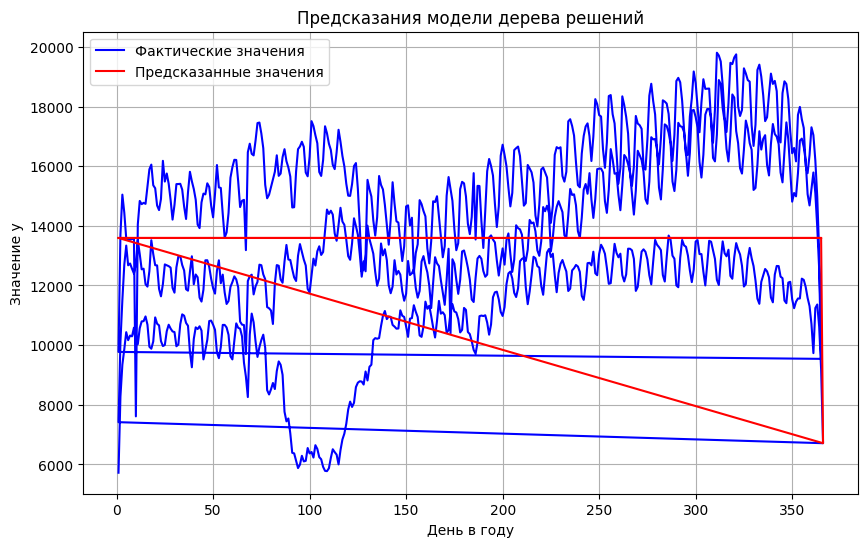

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X.values, y, color='blue', label='Фактические значения')  # Реальные значения
plt.plot(X.values, predictions_tree, color='red', label='Предсказанные значения')  # Предсказанные значения
plt.xlabel('День в году')
plt.ylabel('Значение y')
plt.title('Предсказания модели дерева решений')
plt.legend()
plt.grid(True)
plt.show()
